In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, Dataset, Subset, random_split, DataLoader, TensorDataset
import os
from PIL import Image
from torchvision.models import resnet50
import torch.optim as optim
import torch.nn as nn
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import zipfile
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
with zipfile.ZipFile('/content/400.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
data_root_40 = '/content/400'  

In [ ]:
class Normalize(object):
    def __call__(self, img):
        mean = img.mean(dim=(1, 2), keepdim=True)
        std = img.std(dim=(1, 2), keepdim=True)
        return (img - mean) / std

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((350, 230)),
    transforms.RandomCrop((224, 224)),
    Normalize()
])

In [ ]:
dataset_40 = ImageFolder(root=data_root_40, transform=data_transform)
print(dataset_40.classes)

['benign', 'malignant']


Image Path: /content/400/malignant/SOB_M_DC-14-2985-400-011.png
Label: 1
Class Name: malignant
(700, 460)


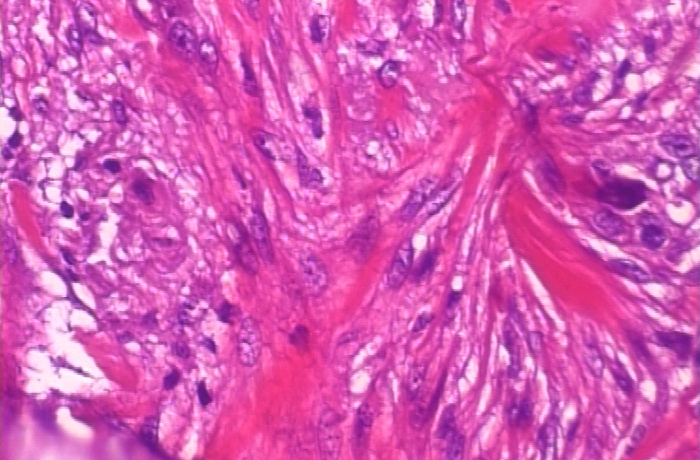

In [ ]:
image_path, label = dataset_40.imgs[1200]
image = Image.open(image_path)
class_name = dataset_40.classes[label]

print("Image Path:", image_path)
print("Label:", label)
print("Class Name:", class_name)
print(image.size)

image.show()

In [ ]:
train_size_40 = int(0.8 * len(dataset_40))
test_size_40 = len(dataset_40) - train_size_40
train_dataset_40, test_dataset_40 = random_split(dataset_40, [train_size_40, test_size_40])
print(type(train_dataset_40))
batch_size = 64

train_loader_40 = DataLoader(train_dataset_40, batch_size=batch_size, shuffle=True)
test_loader_40 = DataLoader(test_dataset_40, batch_size=batch_size)

<class 'torch.utils.data.dataset.Subset'>


**Augmentation**

In [ ]:
alpha = 0.4
num_epochs = 20

In [ ]:
def standard(img, K = 4):
    # Apply random shift
    k1 = random.randint(-K, K)
    k2 = random.randint(-K, K)
    
    padded_img = F.pad(img, (K, K, K, K))
    height, width = padded_img.size(2), padded_img.size(3)

    cx = width // 2 - k2 
    cy = height // 2 + k1

    left = cx - 112 
    top = cy - 112

    cropped_img = padded_img[:, :, top:top+224, left:left+224]
    
    if random.random() < 0.5:
        cropped_img = torchvision.transforms.RandomHorizontalFlip(1)(cropped_img)

    for i in range(len(cropped_img)):
      img_ = cropped_img[i]
      if random.random() < 0.5:
        img_ = torchvision.transforms.RandomHorizontalFlip(1)(img_)
        cropped_img[i] = img_
    return cropped_img

In [ ]:
def cutout(img, k=16):
    height, width = img.size(2), img.size(3)
    mask = torch.ones((height, width), dtype=torch.uint8)
    cx = random.randint(0, width)
    cy = random.randint(0, height)
    
    left = max(0, cx - k // 2)
    right = min(width, cx + k // 2)
    top = max(0, cy - k // 2)
    bottom = min(height, cy + k // 2)
    for i in range(len(img)):
      img_ = img[i]
      if random.random() < 0.5:
        img_[:, top:bottom, left:right] = 0
        img[i] = img_
    return img

In [ ]:
def mixup(x1, y1, x2, y2, alpha):
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y, lam

**Transfer Learning with pretrained resnet50**

In [ ]:
model = resnet50(pretrained=True)
for param in model.parameters():
  param.requires_grad = False
in_features = model.fc.in_features
num_classes = 2 
model.fc = nn.Linear(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:

model.to(device)
train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
  # Training phase
  model.train()
  total_correct = 0
  total_samples = 0
  running_loss = 0
  for images, labels in train_loader_40:
    images = images.to(device)
    images = standard(images)
    labels = labels.to(device)
    indices = torch.randperm(images.size(0))
    mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
    optimizer.zero_grad()
    outputs = model(mixed_images)
    loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
    _, predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)
    loss.backward()
    running_loss += loss.item()
    optimizer.step()
  epoch_train_loss = running_loss / len(train_loader_40)
  train_loss_list.append(epoch_train_loss)
  train_accuracy = total_correct / total_samples
  train_acc_list.append(train_accuracy)
  model.eval()
  with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader_40:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    test_acc_list.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train accuracy: {train_accuracy: .4f} | Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/20], Train accuracy:  0.5934 | Test Accuracy: 0.7637
Epoch [2/20], Train accuracy:  0.6703 | Test Accuracy: 0.8324
Epoch [3/20], Train accuracy:  0.7315 | Test Accuracy: 0.7473
Epoch [4/20], Train accuracy:  0.6848 | Test Accuracy: 0.7775
Epoch [5/20], Train accuracy:  0.7143 | Test Accuracy: 0.8544
Epoch [6/20], Train accuracy:  0.6923 | Test Accuracy: 0.7088
Epoch [7/20], Train accuracy:  0.6978 | Test Accuracy: 0.8187
Epoch [8/20], Train accuracy:  0.7143 | Test Accuracy: 0.8077
Epoch [9/20], Train accuracy:  0.7047 | Test Accuracy: 0.8132
Epoch [10/20], Train accuracy:  0.7088 | Test Accuracy: 0.8462
Epoch [11/20], Train accuracy:  0.7301 | Test Accuracy: 0.7940
Epoch [12/20], Train accuracy:  0.7294 | Test Accuracy: 0.7582
Epoch [13/20], Train accuracy:  0.6978 | Test Accuracy: 0.8462
Epoch [14/20], Train accuracy:  0.7074 | Test Accuracy: 0.8516
Epoch [15/20], Train accuracy:  0.6765 | Test Accuracy: 0.8462
Epoch [16/20], Train accuracy:  0.6999 | Test Accuracy: 0.7692
E

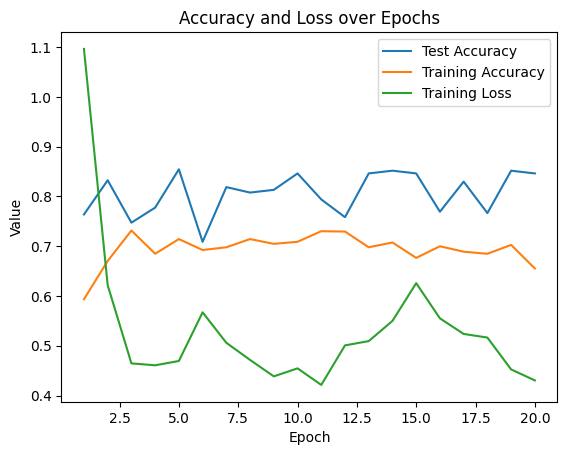

In [ ]:
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

**Manual Training of resnet50**

In [ ]:
train_size_40 = int(0.8 * len(dataset_40))
test_size_40 = len(dataset_40) - train_size_40
train_dataset_40, test_dataset_40 = random_split(dataset_40, [train_size_40, test_size_40])
print(type(train_dataset_40))
batch_size = 64

train_loader_40 = DataLoader(train_dataset_40, batch_size=batch_size, shuffle=True)
test_loader_40 = DataLoader(test_dataset_40, batch_size=batch_size)

<class 'torch.utils.data.dataset.Subset'>


In [ ]:
model = resnet50(pretrained=True)
in_features = model.fc.in_features
num_classes = 2 
model.fc = nn.Linear(in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
model.to(device)
train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
  # Training phase
  model.train()
  i = 0
  total_correct = 0
  total_samples = 0
  running_loss = 0
  for images, labels in train_loader_40:
    images = images.to(device)
    images = standard(images)
    labels = labels.to(device)
    indices = torch.randperm(images.size(0))
    mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
    optimizer.zero_grad()
    outputs = model(mixed_images)
    loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
    _, predicted = torch.max(outputs, 1)
    total_correct += (predicted == labels).sum().item()
    total_samples += labels.size(0)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  epoch_train_loss = running_loss / len(train_loader_40)
  train_loss_list.append(epoch_train_loss)
  train_accuracy = total_correct / total_samples
  train_acc_list.append(train_accuracy)
  model.eval()
  with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader_40:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    test_acc_list.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train accuracy: {train_accuracy: .4f} | Test Accuracy: {accuracy:.4f}")

Epoch [1/20], Train accuracy:  0.6415 | Test Accuracy: 0.6841
Epoch [2/20], Train accuracy:  0.6731 | Test Accuracy: 0.6841
Epoch [3/20], Train accuracy:  0.6772 | Test Accuracy: 0.7033
Epoch [4/20], Train accuracy:  0.6738 | Test Accuracy: 0.8022
Epoch [5/20], Train accuracy:  0.6793 | Test Accuracy: 0.7637
Epoch [6/20], Train accuracy:  0.7246 | Test Accuracy: 0.8159
Epoch [7/20], Train accuracy:  0.6538 | Test Accuracy: 0.6703
Epoch [8/20], Train accuracy:  0.6690 | Test Accuracy: 0.8077
Epoch [9/20], Train accuracy:  0.6813 | Test Accuracy: 0.6319
Epoch [10/20], Train accuracy:  0.6902 | Test Accuracy: 0.8297
Epoch [11/20], Train accuracy:  0.6745 | Test Accuracy: 0.7995
Epoch [12/20], Train accuracy:  0.6614 | Test Accuracy: 0.7720
Epoch [13/20], Train accuracy:  0.7019 | Test Accuracy: 0.8544
Epoch [14/20], Train accuracy:  0.6999 | Test Accuracy: 0.8324
Epoch [15/20], Train accuracy:  0.7946 | Test Accuracy: 0.8242
Epoch [16/20], Train accuracy:  0.6504 | Test Accuracy: 0.8214
E

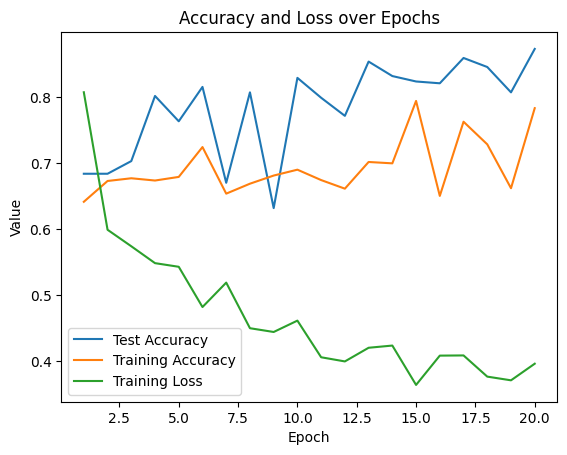

In [ ]:
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
torch.cuda.empty_cache()

**Self-supervised learning depending on only 20% labeled data of the training dataset**

In [ ]:
labeled_dataset_size = len(train_dataset_40)
initial_split_ratio = 0.2
initial_split_size = int(initial_split_ratio * labeled_dataset_size)
remaining_split_size = labeled_dataset_size - initial_split_size
dataset_initial_40 = Subset(train_dataset_40, range(initial_split_size)).dataset
dataset_remaining_40 = Subset(train_dataset_40, range(initial_split_size, labeled_dataset_size)).dataset

In [ ]:
print(type(dataset_initial_40))
print(type(dataset_remaining_40))

<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [ ]:
model = resnet50(pretrained=True)
in_features = model.fc.in_features
num_classes = 2 
model.fc = nn.Linear(in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 13
batch_size = 16
ss_train_loader_40 = DataLoader(dataset_initial_40, batch_size=batch_size, shuffle=True)

In [ ]:
len(ss_train_loader_40)

91

In [ ]:
model.to(device)
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    model.train()
    for images, labels in ss_train_loader_40:
      images = images.to(device)
      images = standard(images)
      labels = labels.to(device)
      indices = torch.randperm(images.size(0))
      mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
      optimizer.zero_grad()
      outputs = model(mixed_images)
      loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)
    train_accuracy = total_correct / total_samples

    print(train_accuracy)

0.6435439560439561
0.6785714285714286
0.6792582417582418
0.7129120879120879
0.7108516483516484
0.7197802197802198
0.6929945054945055
0.7252747252747253
0.7493131868131868
0.7479395604395604
0.760989010989011
0.7300824175824175
0.742445054945055


In [ ]:
confidence_threshold = 0.9 

print(dataset_initial_40)
ss_unlabeled_train_loader_40 = DataLoader(dataset_remaining_40, batch_size=batch_size, shuffle=False)

train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(num_epochs):
  model.eval()
  with torch.no_grad():
    for images, _ in ss_unlabeled_train_loader_40:
      images = images.to(device)
      outputs = model(images)
      probabilities = torch.softmax(outputs, dim=1)
      max_probabilities, predicted_labels = torch.max(probabilities, dim=1)

      confident_indices = torch.where(max_probabilities > confidence_threshold)[0]

      for index in confident_indices:
        dataset_initial_40.dataset.targets.append(predicted_labels[index].item())
        dataset_initial_40.dataset.samples.append((images[index], predicted_labels[index].item()))

  ss_train_loader_40 = DataLoader(dataset_initial_40, batch_size=batch_size, shuffle=True)
  model.train()
  total_correct = 0
  total_samples = 0
  running_loss = 0
  for images, labels in ss_train_loader_40:
      images = images.to(device)
      images = standard(images)
      labels = labels.to(device)
      indices = torch.randperm(images.size(0))
      mixed_images, mixed_labels, lam = mixup(images, labels, images[indices], labels[indices], alpha)
      optimizer.zero_grad()
      outputs = model(mixed_images)
      loss = lam * criterion(outputs, labels) + (1-lam) * criterion(outputs, labels[indices])
      _, predicted = torch.max(outputs, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    
  epoch_train_loss = running_loss / len(train_loader_40)
  train_loss_list.append(epoch_train_loss)
  train_accuracy = total_correct / total_samples
  train_acc_list.append(train_accuracy)

  train_accuracy = total_correct / total_samples
  model.eval()
  with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for images, labels in test_loader_40:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)

      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    test_acc_list.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train accuracy: {train_accuracy: .4f} | Test Accuracy: {accuracy:.4f}")

Epoch [1/13], Train accuracy:  0.7562 | Test Accuracy: 0.8846
Epoch [2/13], Train accuracy:  0.7273 | Test Accuracy: 0.8489
Epoch [3/13], Train accuracy:  0.7514 | Test Accuracy: 0.9093
Epoch [4/13], Train accuracy:  0.7280 | Test Accuracy: 0.9203
Epoch [5/13], Train accuracy:  0.7500 | Test Accuracy: 0.9203
Epoch [6/13], Train accuracy:  0.7370 | Test Accuracy: 0.8489
Epoch [7/13], Train accuracy:  0.7404 | Test Accuracy: 0.8049
Epoch [8/13], Train accuracy:  0.7562 | Test Accuracy: 0.8571
Epoch [9/13], Train accuracy:  0.7685 | Test Accuracy: 0.9313
Epoch [10/13], Train accuracy:  0.7837 | Test Accuracy: 0.8901
Epoch [11/13], Train accuracy:  0.7555 | Test Accuracy: 0.9368
Epoch [12/13], Train accuracy:  0.7404 | Test Accuracy: 0.8984
Epoch [13/13], Train accuracy:  0.7562 | Test Accuracy: 0.9066


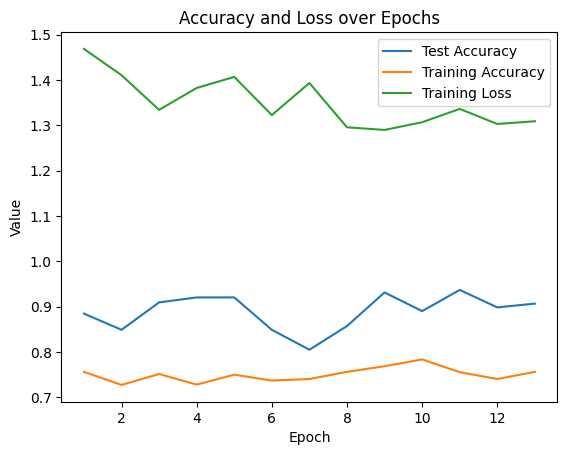

In [ ]:
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Accuracy and Loss over Epochs')
plt.legend()
plt.show()